# Bike Sharing Case Study using Linear Regression

### Problem Statement

A bike sharing company BoomBikes wants to understand the factors on which the demand for shared bikes depends. 

The company wants to know:
1. Which variables are significant in predicting the demand for shared bikes.
2. How well those variables describe the bike demands.

The firm wants to create a Linear Regression model to understand the demand of shared bikes with the available independent variables in the dataset. The model will subsequently be used by the management to understand how exactly the demands vary with different features, giving important business insights. Using the valuable information the company will refine their business strategy to meet the demand levels and customer expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market

### Solution Approach
1. Read and visualize Data
2. Preparing data for modelling
3. Training model
4. Residual Analysis
5. Predictions and Evaluation

### Step-1 Reading and Visualize Data

In [805]:
# importing required library 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import calendar

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression




In [806]:
# Read data from CSV file.
bike_df = pd.read_csv('day.csv')
bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


bike_df.shape

In [807]:
# There are no Null values.
# All the columns except dteday are numerical datatypes (float or int).
# # dteday is of type object. 
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


#### From data dictionary we understand that 
1. We have year and Month columns so the column dteday is redundant.
2. The cnt column is sum of casual and registered, so these columns can be dropped.
3. The instant column is and index, so it can be dropped.

In [808]:
bike_df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=True)

In [809]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


In [810]:
# Converting the columns to their actual string values.
bike_df.season=bike_df.season.map({1: 'Spring',2:'Summer',3:'Fall',4:'Winter'})
bike_df.weathersit=bike_df.weathersit.map({1:'Clear',2:'Mist+Cloudy', 3:'LightSnow+Rain',4:'HeavySnow+Rain+Fog'})
bike_df.weekday=bike_df.weekday.map({0:"Sunday",1:"Monday",2:"Tuesday",3:"Wednesday",4:"Thrusday",5:"Friday",6:"Saturday"})
bike_df.mnth = bike_df.mnth.apply(lambda x: calendar.month_name[x])

In [811]:
bike_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,Spring,0,January,0,Saturday,0,Mist+Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,Spring,0,January,0,Sunday,0,Mist+Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,Spring,0,January,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,Spring,0,January,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,Spring,0,January,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


#### Univariate Analysis

In [812]:
# Sagregating the numerical and categorical variables
cat_varlist = ['season',  'yr', 'mnth','holiday', 'weekday', 'workingday', 'weathersit']
num_varlist = ['temp','atemp','hum','windspeed','cnt']

Numerical Variables

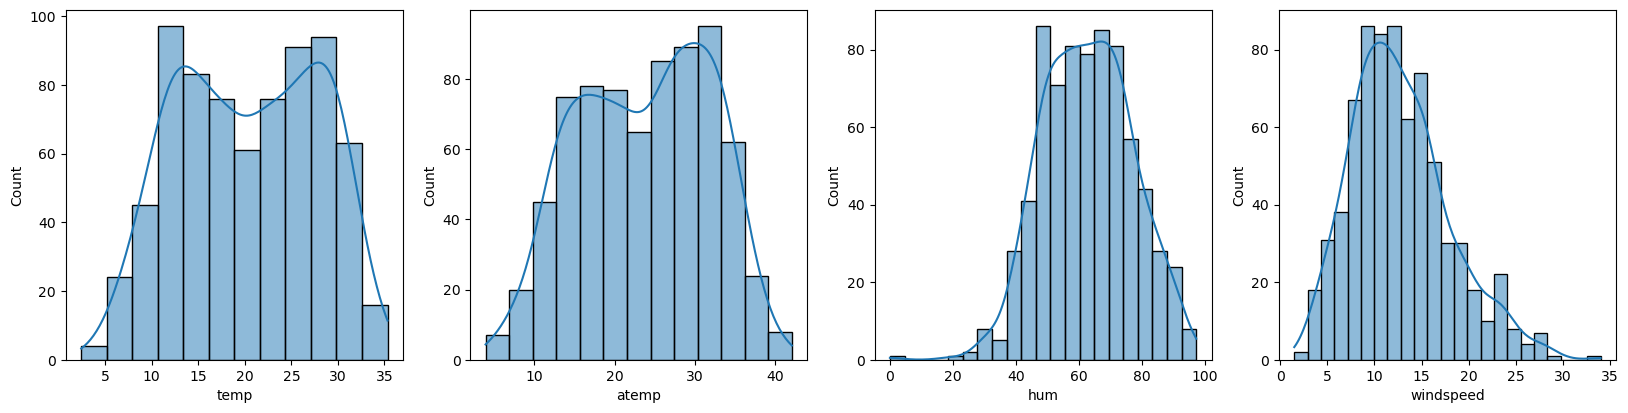

In [813]:
num_varlist = ['temp','atemp','hum','windspeed']
plt.figure(figsize=(20,10))
for i in enumerate(num_varlist):
    plt.subplot(2,4,i[0]+1)
    sns.histplot(bike_df[i[1]], kde=True)
plt.show()

Categorical Variables

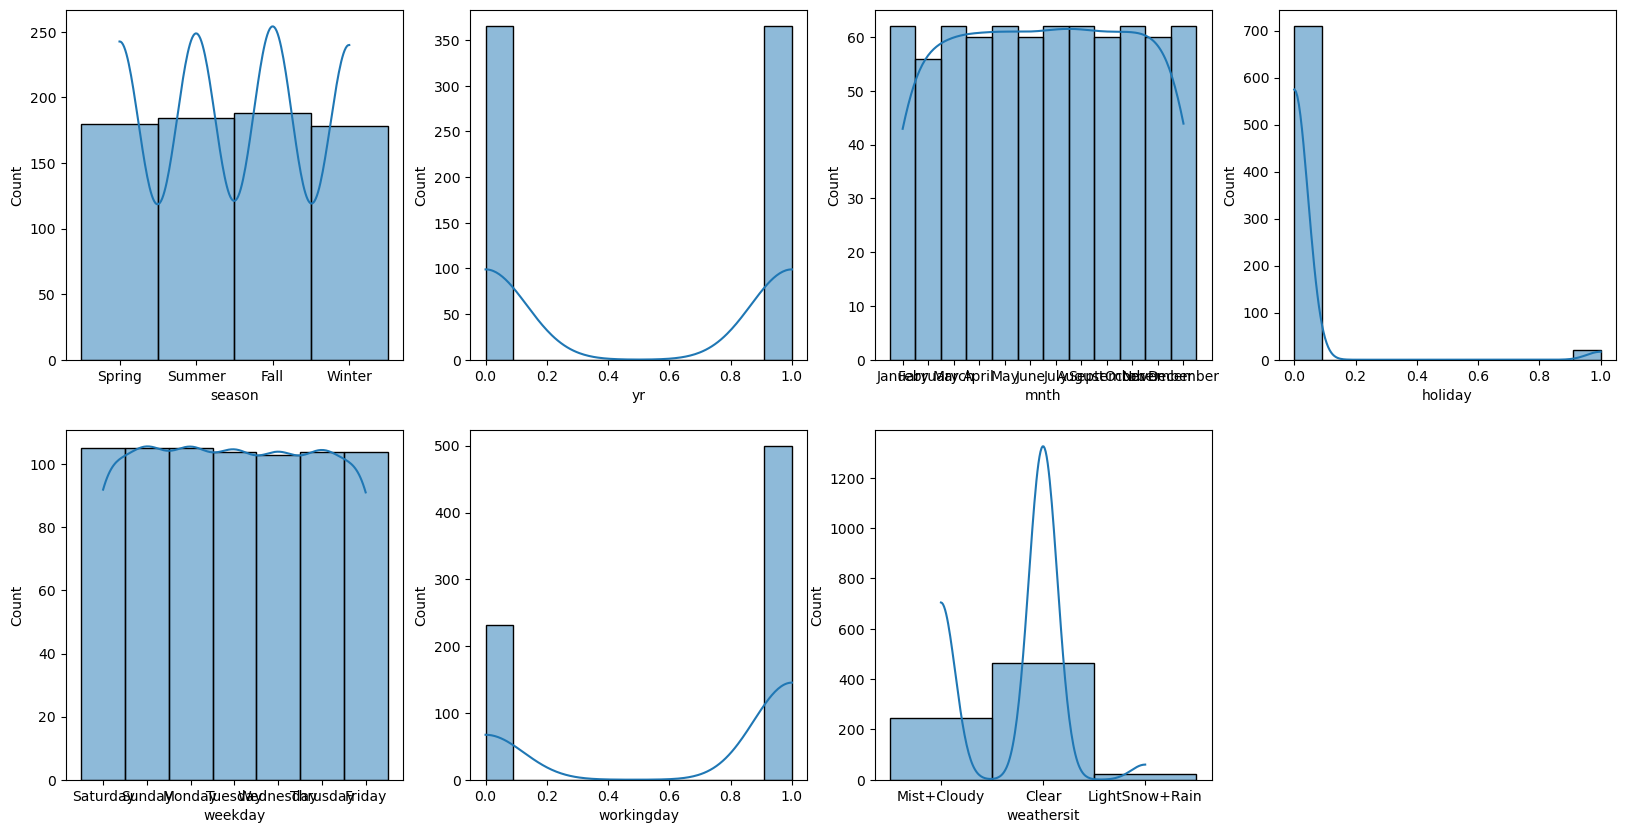

In [814]:
cat_varlist = ['season',  'yr', 'mnth','holiday', 'weekday', 'workingday', 'weathersit']
plt.figure(figsize=(20,10))
for i in enumerate(cat_varlist):
    plt.subplot(2,4,i[0]+1)
    sns.histplot(bike_df[i[1]], kde=True)
plt.show()

#### Bivariate Analysis

Numerical Variables

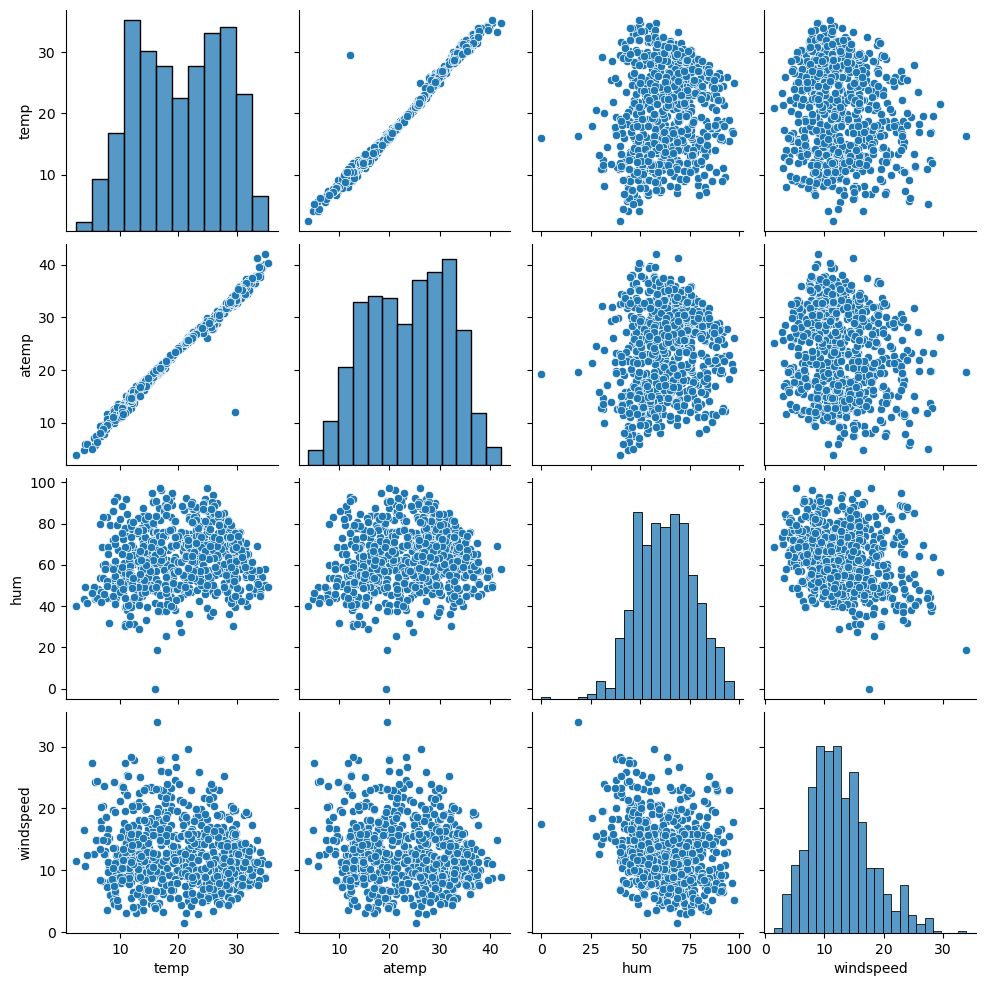

In [815]:
#visualize numerical variables
sns.pairplot(bike_df[num_varlist])
plt.show()

In [816]:
# The cnt is the target variable.
# The scatter plot shows that the cnt have positive correlation with temp and atemp variables.
# The hum and windspeed looks to be quite scattered but in the positive quadrant.

Categorical Variables

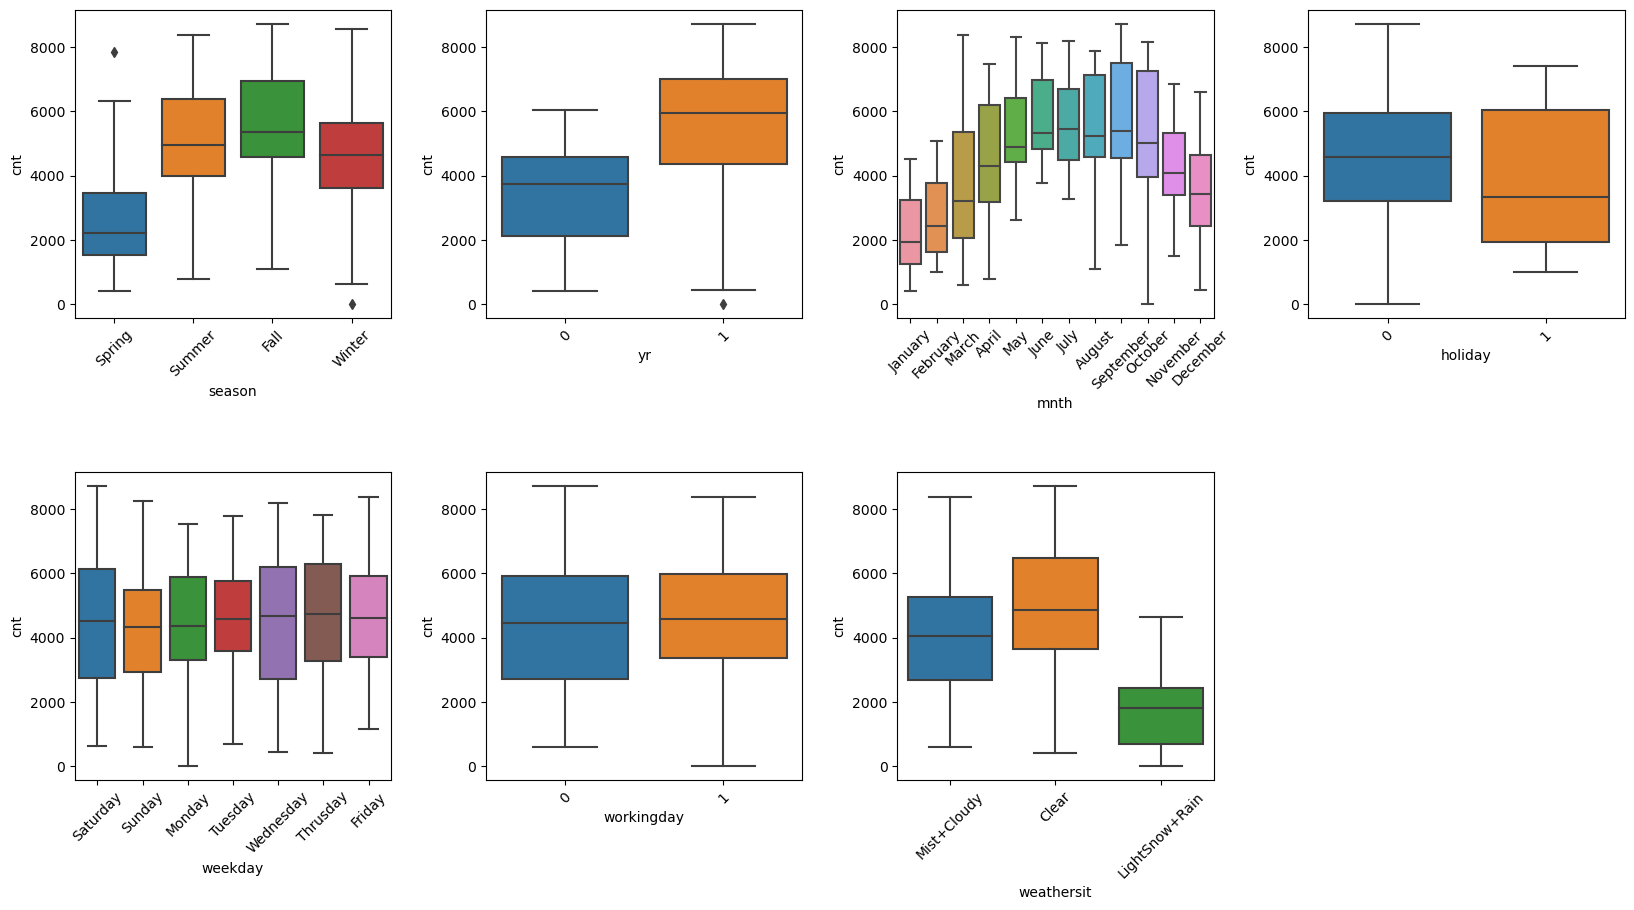

In [817]:
#visualize categorical variable
plt.figure(figsize=(20,10))

for i in enumerate(cat_varlist):
    plt.subplot(2,4,i[0]+1)
    plt.xticks(rotation=45) 
    plt.subplots_adjust(hspace=0.5, wspace=0.3) 
    sns.boxplot(x=i[1], y='cnt', data=bike_df)


The following are the observations
1. On Clear days, the demand is on higher side.
2. on Saturday's we see a slightly higher number of bike sharing.
3. In non-holiday days the demand is on higher side.

### Step 2. Preparing data for modelling

In [818]:
# Clist of categorical variables which have more than 2 values.
dummy_varlist = ['season','mnth','weekday','weathersit']
dummy=bike_df[dummy_varlist]
dummy.head()

,season,mnth,weekday,weathersit
0,Spring,January,Saturday,Mist+Cloudy
1,Spring,January,Sunday,Mist+Cloudy
2,Spring,January,Monday,Clear
3,Spring,January,Tuesday,Clear
4,Spring,January,Wednesday,Clear


In [819]:
# Create dummy variables
dummy_df = pd.get_dummies(dummy, dtype='Int64', drop_first=True)
dummy_df.head()

,season_Spring,season_Summer,season_Winter,mnth_August,mnth_December,mnth_February,mnth_January,mnth_July,mnth_June,mnth_March,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thrusday,weekday_Tuesday,weekday_Wednesday,weathersit_LightSnow+Rain,weathersit_Mist+Cloudy
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [820]:
#Concattenate the dummy variables with the bike dataframe
bike_df = pd.concat([bike_df, dummy_df], axis=1)

In [821]:
bike_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thrusday,weekday_Tuesday,weekday_Wednesday,weathersit_LightSnow+Rain,weathersit_Mist+Cloudy
0,Spring,0,January,0,Saturday,0,Mist+Cloudy,14.110847,18.18125,80.5833,...,0,0,0,1,0,0,0,0,0,1
1,Spring,0,January,0,Sunday,0,Mist+Cloudy,14.902598,17.68695,69.6087,...,0,0,0,0,1,0,0,0,0,1
2,Spring,0,January,0,Monday,1,Clear,8.050924,9.47025,43.7273,...,0,0,1,0,0,0,0,0,0,0
3,Spring,0,January,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,...,0,0,0,0,0,0,1,0,0,0
4,Spring,0,January,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,...,0,0,0,0,0,0,0,1,0,0


In [822]:
#Dropping the dummy variable list
bike_df.drop(dummy_varlist, axis=1, inplace=True)

In [823]:
bike_df.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'season_Spring', 'season_Summer', 'season_Winter', 'mnth_August',
       'mnth_December', 'mnth_February', 'mnth_January', 'mnth_July',
       'mnth_June', 'mnth_March', 'mnth_May', 'mnth_November', 'mnth_October',
       'mnth_September', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thrusday', 'weekday_Tuesday',
       'weekday_Wednesday', 'weathersit_LightSnow+Rain',
       'weathersit_Mist+Cloudy'],
      dtype='object')

In [824]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   yr                         730 non-null    int64  
 1   holiday                    730 non-null    int64  
 2   workingday                 730 non-null    int64  
 3   temp                       730 non-null    float64
 4   atemp                      730 non-null    float64
 5   hum                        730 non-null    float64
 6   windspeed                  730 non-null    float64
 7   cnt                        730 non-null    int64  
 8   season_Spring              730 non-null    Int64  
 9   season_Summer              730 non-null    Int64  
 10  season_Winter              730 non-null    Int64  
 11  mnth_August                730 non-null    Int64  
 12  mnth_December              730 non-null    Int64  
 13  mnth_February              730 non-null    Int64  

In [825]:
# Splitting the dataframe into Training and Test dataset with 70-30 split.
bike_train, bike_test = train_test_split(bike_df, train_size=0.7, random_state=100)
print(f'The shape train dataset - {bike_train.shape}')
print(f'The shape of test dataset - {bike_test.shape}')

The shape train dataset - (510, 30)
The shape of test dataset - (220, 30)


In [826]:
# Rescaling the variables

#1. Create object

scaler = MinMaxScaler()

#2. Fit on data for numerical variables 
bike_train[num_varlist] = scaler.fit_transform(bike_train[num_varlist])

bike_train.head()


,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thrusday,weekday_Tuesday,weekday_Wednesday,weathersit_LightSnow+Rain,weathersit_Mist+Cloudy
576,1,0,1,0.815169,0.766351,0.725633,0.264686,7216,0,0,...,0,0,0,0,0,0,1,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,4066,1,0,...,0,0,0,1,0,0,0,0,0,1
728,1,0,0,0.245101,0.200348,0.498067,0.663106,1796,1,0,...,0,0,0,0,1,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,4220,0,1,...,0,0,0,1,0,0,0,0,0,1
111,0,0,1,0.345824,0.318819,0.751824,0.380981,1683,0,1,...,0,0,0,0,0,0,0,0,0,1


In [827]:
bike_train[num_varlist].describe()

,temp,atemp,hum,windspeed
count,510.000000,510.000000,510.000000,510.000000
mean,0.537440,0.513156,0.650480,0.320883
std,0.225858,0.212410,0.145846,0.169803
min,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.332086,0.538643,0.199179
50%,0.542596,0.529718,0.653714,0.296763
75%,0.735215,0.688457,0.754830,0.414447
max,1.000000,1.000000,1.000000,1.000000


In [828]:
y_train = bike_train.pop('cnt')
x_train = bike_train

In [829]:
y_train.head()

576    7216
426    4066
728    1796
482    4220
111    1683
Name: cnt, dtype: int64

In [830]:
x_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_Spring,season_Summer,season_Winter,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thrusday,weekday_Tuesday,weekday_Wednesday,weathersit_LightSnow+Rain,weathersit_Mist+Cloudy
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0,0,0,...,0,0,0,0,0,0,1,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,1,0,0,...,0,0,0,1,0,0,0,0,0,1
728,1,0,0,0.245101,0.200348,0.498067,0.663106,1,0,0,...,0,0,0,0,1,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0,1,0,...,0,0,0,1,0,0,0,0,0,1
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0,1,0,...,0,0,0,0,0,0,0,0,0,1


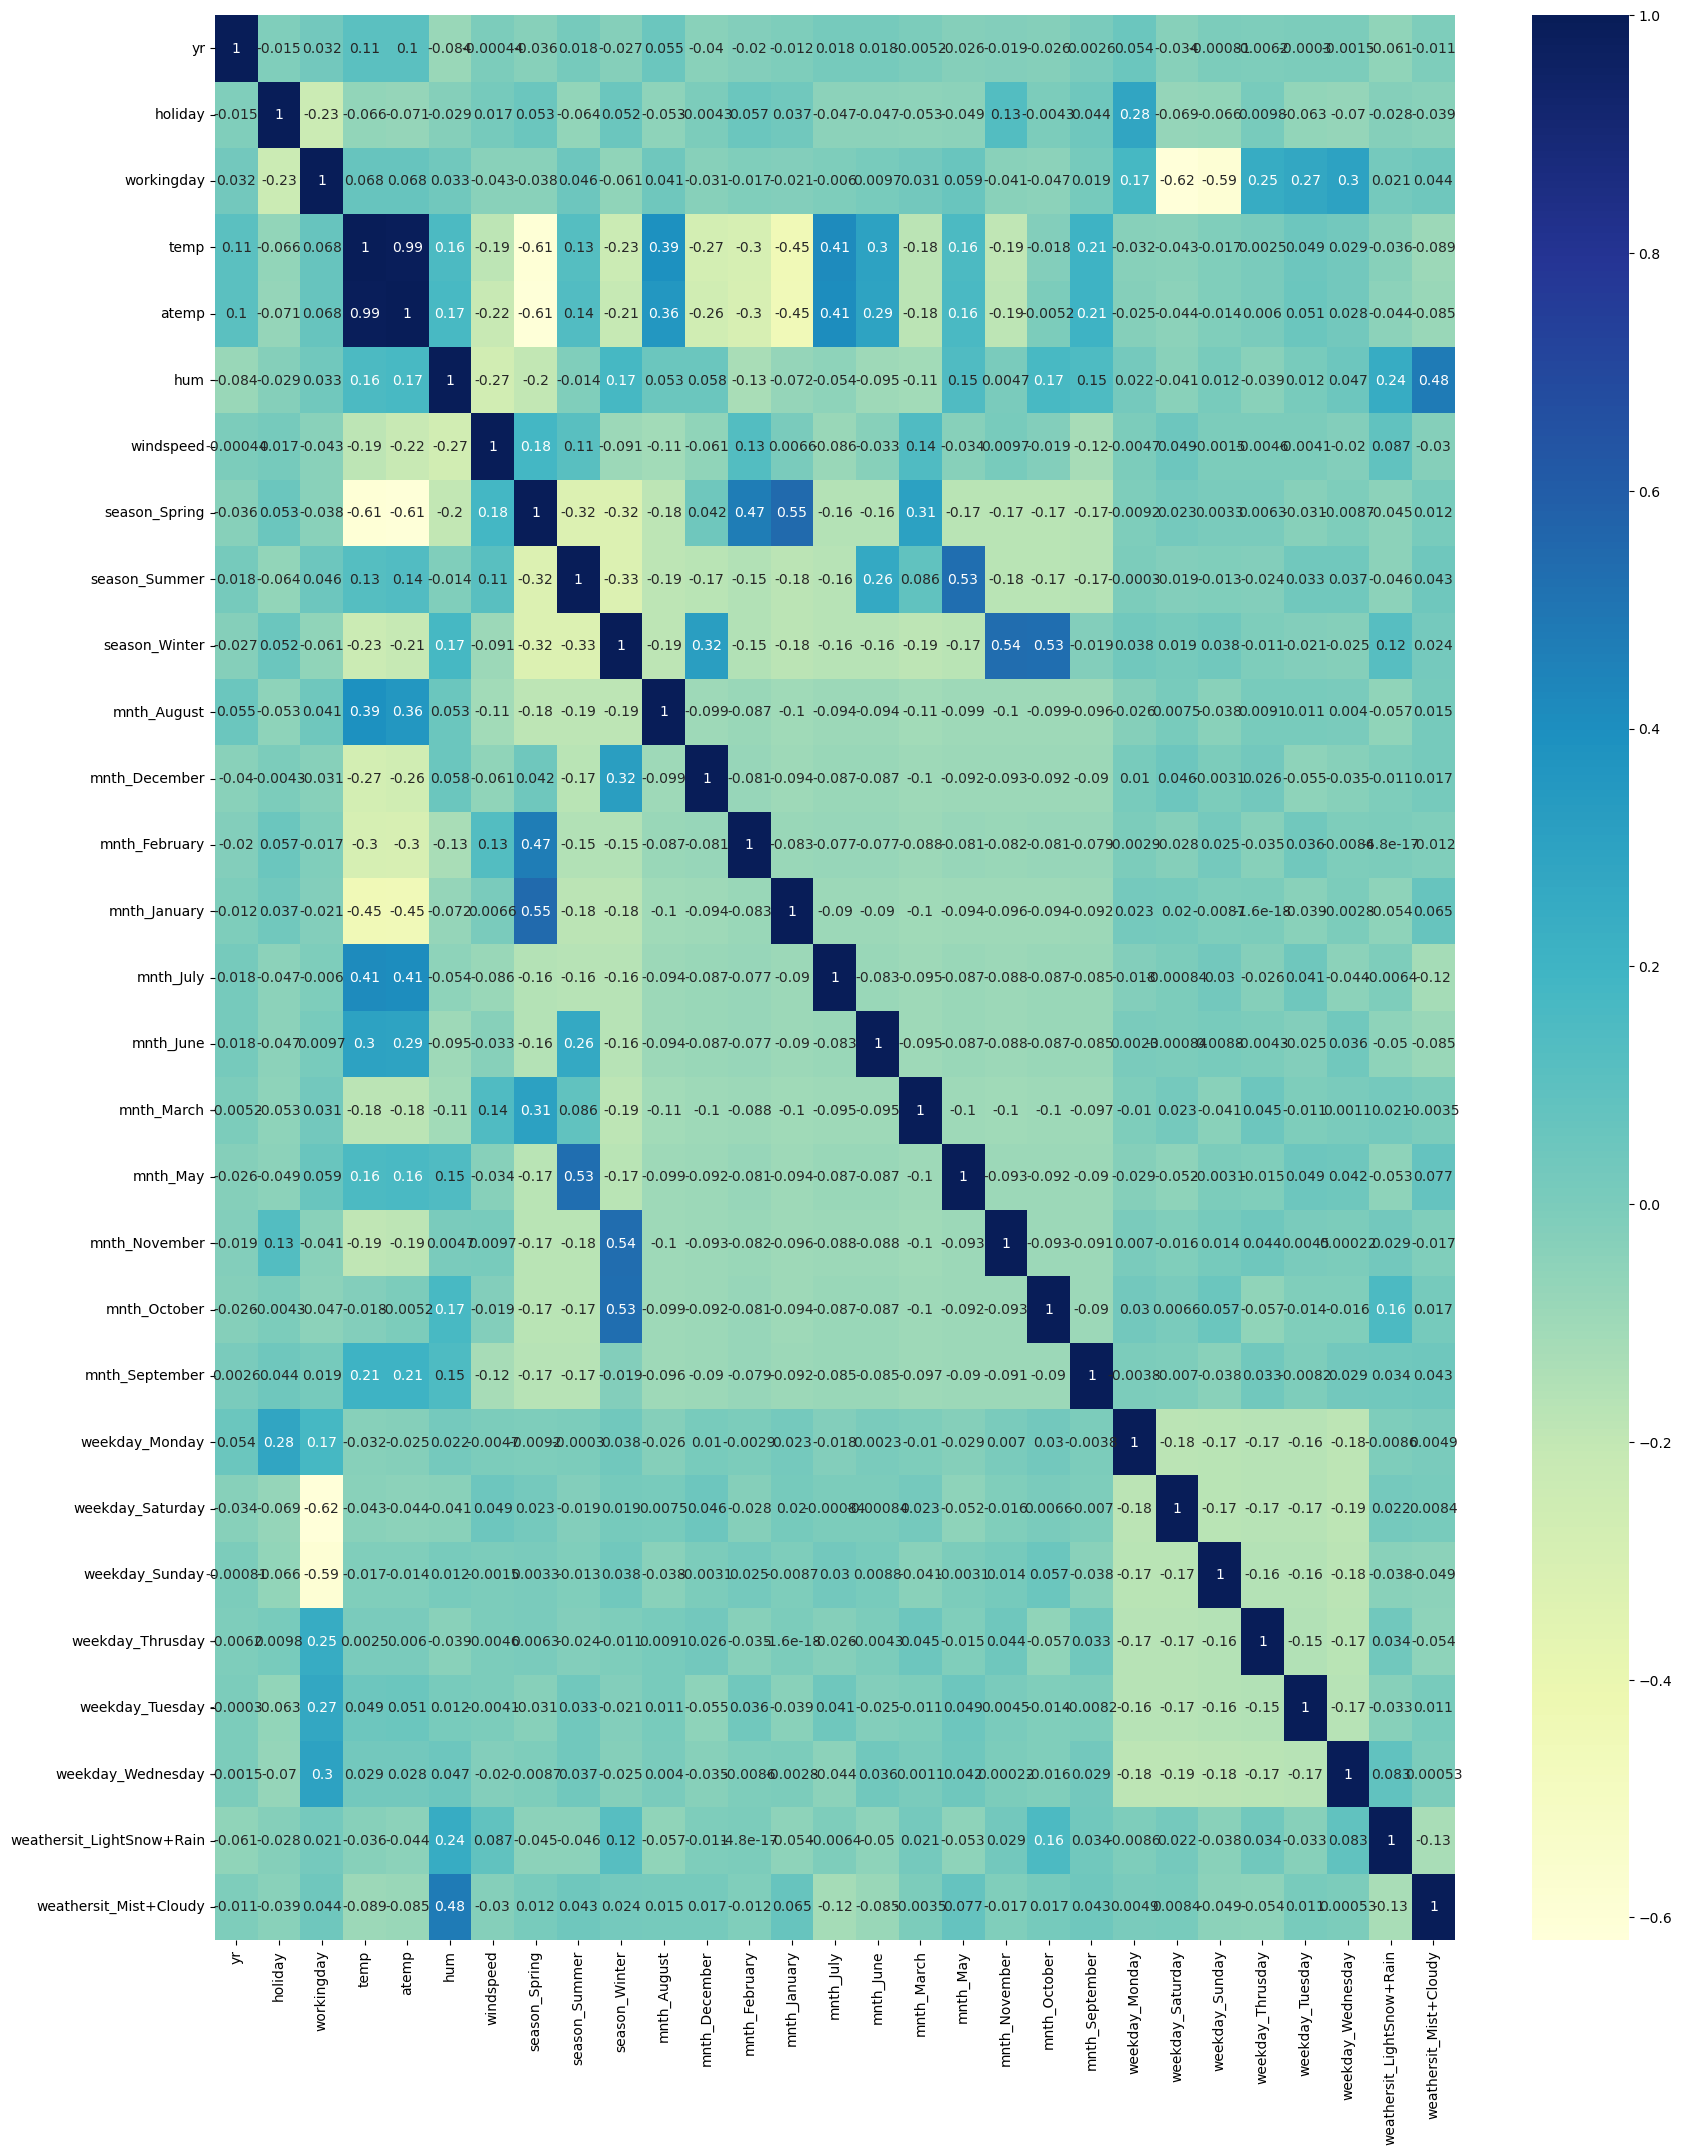

In [831]:
plt.figure(figsize = (20, 25))
sns.heatmap(x_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

### Step 3. Training model

We will use a mix of automated and manual approach so that we can achieve the correct model in less iterations. For the initial phase, we will use the RFE approach number of variables as 20. Once we get the stats for the model, then we will use the p-value and VIF value to decide on the variables which can be eiliminated.

In [832]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 510 entries, 576 to 520
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   yr                         510 non-null    int64  
 1   holiday                    510 non-null    int64  
 2   workingday                 510 non-null    int64  
 3   temp                       510 non-null    float64
 4   atemp                      510 non-null    float64
 5   hum                        510 non-null    float64
 6   windspeed                  510 non-null    float64
 7   season_Spring              510 non-null    Int64  
 8   season_Summer              510 non-null    Int64  
 9   season_Winter              510 non-null    Int64  
 10  mnth_August                510 non-null    Int64  
 11  mnth_December              510 non-null    Int64  
 12  mnth_February              510 non-null    Int64  
 13  mnth_January               510 non-null    Int64  
 1

#### RFE for Automated feature selection

In [833]:
# Running RFE with the output number of the variable equal to 20
lm = LinearRegression()
lm.fit(x_train, y_train)

rfe = RFE(estimator=lm, n_features_to_select=20)           # running RFE
rfe = rfe.fit(x_train, y_train)

In [834]:
list(zip(x_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 6),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_Spring', False, 7),
 ('season_Summer', True, 1),
 ('season_Winter', True, 1),
 ('mnth_August', True, 1),
 ('mnth_December', True, 1),
 ('mnth_February', True, 1),
 ('mnth_January', True, 1),
 ('mnth_July', True, 1),
 ('mnth_June', False, 8),
 ('mnth_March', False, 2),
 ('mnth_May', True, 1),
 ('mnth_November', True, 1),
 ('mnth_October', False, 3),
 ('mnth_September', True, 1),
 ('weekday_Monday', False, 10),
 ('weekday_Saturday', True, 1),
 ('weekday_Sunday', True, 1),
 ('weekday_Thrusday', False, 5),
 ('weekday_Tuesday', False, 9),
 ('weekday_Wednesday', False, 4),
 ('weathersit_LightSnow+Rain', True, 1),
 ('weathersit_Mist+Cloudy', True, 1)]

In [835]:
col = x_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_Summer', 'season_Winter', 'mnth_August', 'mnth_December',
       'mnth_February', 'mnth_January', 'mnth_July', 'mnth_May',
       'mnth_November', 'mnth_September', 'weekday_Saturday', 'weekday_Sunday',
       'weathersit_LightSnow+Rain', 'weathersit_Mist+Cloudy'],
      dtype='object')

In [836]:
x_train.columns[~rfe.support_]

Index(['atemp', 'season_Spring', 'mnth_June', 'mnth_March', 'mnth_October',
       'weekday_Monday', 'weekday_Thrusday', 'weekday_Tuesday',
       'weekday_Wednesday'],
      dtype='object')

After RFE we have the following model/dataset

In [837]:
x_train_rfe = x_train[col]

In [838]:
x_train_rfe.head()

,yr,holiday,workingday,temp,hum,windspeed,season_Summer,season_Winter,mnth_August,mnth_December,mnth_February,mnth_January,mnth_July,mnth_May,mnth_November,mnth_September,weekday_Saturday,weekday_Sunday,weathersit_LightSnow+Rain,weathersit_Mist+Cloudy
576,1,0,1,0.815169,0.725633,0.264686,0,0,0,0,0,0,1,0,0,0,0,0,0,0
426,1,0,0,0.442393,0.640189,0.255342,0,0,0,0,0,0,0,0,0,0,1,0,0,1
728,1,0,0,0.245101,0.498067,0.663106,0,0,0,1,0,0,0,0,0,0,0,1,0,0
482,1,0,0,0.395666,0.504508,0.188475,1,0,0,0,0,0,0,0,0,0,1,0,0,1
111,0,0,1,0.345824,0.751824,0.380981,1,0,0,0,0,0,0,0,0,0,0,0,0,1


#### Manual Feature Selection
Elimating variables with p-value > 0.05 and VIF > 5
<br><br>
The variables will be dropped one each time and the model will be recreated till we get model which satisfies the condition
1. p-value is less than 0.05
2. VIF of variables is less than 5

In [839]:
# Add constant
x_train_rfe_sm = sm.add_constant(x_train_rfe)

# Converting explicitly to float to avoid valueerror
x_train_rfe_sm = x_train_rfe_sm.astype(float)
y_train = y_train.astype(float)

In [840]:
#Create model
lr = sm.OLS(y_train, x_train_rfe_sm)
# Fit model
lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     147.1
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          1.83e-188
Time:                        22:20:09   Log-Likelihood:                -4101.7
No. Observations:                 510   AIC:                             8243.
Df Residuals:                     490   BIC:                             8328.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      1824.4465    223.148      8.176      0.000    1386.001    2262.892
yr                         2005.8923     69.297     28.946      0.000    1869.737    2142.048
holiday                     -78.6992    185.251     -0.425      0.671    -442.684     285.285
workingday                  734.3546     80.037      9.175      0.000     577.097     891.612
temp                       4168.6038    300.384     13.878      0.000    3578.404    4758.804
hum                       -1397.2877    326.369     -4.281      0.000   -2038.543    -756.032
windspeed                 -1662.0414    220.422     -7.540      0.000   -2095.130   -1228.953
season_Summer               608.2135    132.037      4.606      0.000     348.784     867.643
season_Winter              1204.9024    127.806      9.428      0.000     953.788    1456.017
mnth_August                 331.0354    169.143      1.957      0.051      -1.300     663.371
mnth_December              -399.8064    157.830     -2.533      0.012    -709.913     -89.700
mnth_February              -371.2042    181.911     -2.041      0.042    -728.626     -13.783
mnth_January               -616.4163    182.410     -3.379      0.001    -974.819    -258.014
mnth_July                  -166.6098    185.299     -0.899      0.369    -530.689     197.469
mnth_May                    178.1813    149.872      1.189      0.235    -116.289     472.652
mnth_November              -347.4054    161.905     -2.146      0.032    -665.520     -29.291
mnth_September              874.0831    157.694      5.543      0.000     564.243    1183.923
weekday_Saturday            815.3454     97.954      8.324      0.000     622.883    1007.808
weekday_Sunday              353.4458    102.684      3.442      0.001     151.691     555.201
weathersit_LightSnow+Rain -2177.2824    226.864     -9.597      0.000   -2623.029   -1731.536
weathersit_Mist+Cloudy     -501.3995     89.817     -5.582      0.000    -677.874    -324.925
==============================================================================
Omnibus:                       76.511   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.669
Skew:                          -0.751   Prob(JB):                     4.39e-44
Kurtosis:                       5.673   Cond. No.                     1.43e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.34e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [841]:
# VIF of variable
x_train_rfe = x_train_rfe.astype(float)

vif=pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif=vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
2,workingday,43.65
16,weekday_Saturday,10.56
17,weekday_Sunday,10.22
3,temp,3.97
6,season_Summer,2.81
1,holiday,2.73
7,season_Winter,2.63
11,mnth_January,2.32
8,mnth_August,2.15
12,mnth_July,2.10


In [842]:
# Remove holiday column as it's p-value is 0.67
x_train_rfe.drop('holiday', axis=1, inplace=True)


In [843]:
# Add constant
x_train_rfe_sm = sm.add_constant(x_train_rfe)

# Converting explicitly to float to avoid valueerror
x_train_rfe_sm = x_train_rfe_sm.astype(float)
y_train = y_train.astype(float)

In [844]:
#Create model
lr = sm.OLS(y_train, x_train_rfe_sm)
# Fit model
lr_model = lr.fit()
#paramas
lr_model.params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     147.1
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          1.83e-188
Time:                        22:20:09   Log-Likelihood:                -4101.7
No. Observations:                 510   AIC:                             8243.
Df Residuals:                     490   BIC:                             8328.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      1745.7473    351.656      4.964      0.000    1054.807    2436.687
yr                         2005.8923     69.297     28.946      0.000    1869.737    2142.048
workingday                  813.0538    220.999      3.679      0.000     378.831    1247.277
temp                       4168.6038    300.384     13.878      0.000    3578.404    4758.804
hum                       -1397.2877    326.369     -4.281      0.000   -2038.543    -756.032
windspeed                 -1662.0414    220.422     -7.540      0.000   -2095.130   -1228.953
season_Summer               608.2135    132.037      4.606      0.000     348.784     867.643
season_Winter              1204.9024    127.806      9.428      0.000     953.788    1456.017
mnth_August                 331.0354    169.143      1.957      0.051      -1.300     663.371
mnth_December              -399.8064    157.830     -2.533      0.012    -709.913     -89.700
mnth_February              -371.2042    181.911     -2.041      0.042    -728.626     -13.783
mnth_January               -616.4163    182.410     -3.379      0.001    -974.819    -258.014
mnth_July                  -166.6098    185.299     -0.899      0.369    -530.689     197.469
mnth_May                    178.1813    149.872      1.189      0.235    -116.289     472.652
mnth_November              -347.4054    161.905     -2.146      0.032    -665.520     -29.291
mnth_September              874.0831    157.694      5.543      0.000     564.243    1183.923
weekday_Saturday            894.0446    233.895      3.822      0.000     434.484    1353.605
weekday_Sunday              432.1450    234.603      1.842      0.066     -28.807     893.097
weathersit_LightSnow+Rain -2177.2824    226.864     -9.597      0.000   -2623.029   -1731.536
weathersit_Mist+Cloudy     -501.3995     89.817     -5.582      0.000    -677.874    -324.925
==============================================================================
Omnibus:                       76.511   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.669
Skew:                          -0.751   Prob(JB):                     4.39e-44
Kurtosis:                       5.673   Cond. No.                         25.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [845]:
# VIF of variable
x_train_rfe = x_train_rfe.astype(float)

vif=pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif=vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
3,hum,31.29
2,temp,22.73
1,workingday,17.24
15,weekday_Saturday,4.64
4,windspeed,4.63
16,weekday_Sunday,4.50
5,season_Summer,3.59
6,season_Winter,3.44
7,mnth_August,2.37
18,weathersit_Mist+Cloudy,2.29


In [846]:
# Remove mnth_July column due to it's high p-value of 0.369
x_train_rfe.drop('mnth_July', axis=1, inplace=True)

In [847]:
# Add constant
x_train_rfe_sm = sm.add_constant(x_train_rfe)

# Converting explicitly to float to avoid valueerror
x_train_rfe_sm = x_train_rfe_sm.astype(float)
y_train = y_train.astype(float)

In [848]:
#Create model
lr = sm.OLS(y_train, x_train_rfe_sm)
# Fit model
lr_model = lr.fit()
#paramas
lr_model.params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     155.3
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          2.16e-189
Time:                        22:20:09   Log-Likelihood:                -4102.1
No. Observations:                 510   AIC:                             8242.
Df Residuals:                     491   BIC:                             8323.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      1757.8999    351.328      5.004      0.000    1067.609    2448.191
yr                         2008.5797     69.219     29.018      0.000    1872.578    2144.581
workingday                  805.6470    220.802      3.649      0.000     371.813    1239.481
temp                       4035.2287    261.152     15.452      0.000    3522.115    4548.342
hum                       -1375.9242    325.440     -4.228      0.000   -2015.350    -736.498
windspeed                 -1647.8680    219.814     -7.497      0.000   -2079.761   -1215.975
season_Summer               659.5500    119.031      5.541      0.000     425.676     893.424
season_Winter              1239.2952    121.924     10.165      0.000     999.739    1478.851
mnth_August                 416.1204    140.168      2.969      0.003     140.718     691.523
mnth_December              -401.3133    157.790     -2.543      0.011    -711.340     -91.286
mnth_February              -355.1858    181.001     -1.962      0.050    -710.818       0.446
mnth_January               -609.5856    182.216     -3.345      0.001    -967.605    -251.566
mnth_May                    190.6986    149.195      1.278      0.202    -102.440     483.837
mnth_November              -352.0974    161.790     -2.176      0.030    -669.983     -34.212
mnth_September              936.4508    141.592      6.614      0.000     658.250    1214.652
weekday_Saturday            884.2065    233.593      3.785      0.000     425.241    1343.172
weekday_Sunday              422.3886    234.306      1.803      0.072     -37.977     882.755
weathersit_LightSnow+Rain -2185.8389    226.620     -9.645      0.000   -2631.104   -1740.574
weathersit_Mist+Cloudy     -505.4622     89.686     -5.636      0.000    -681.678    -329.246
==============================================================================
Omnibus:                       78.994   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.667
Skew:                          -0.768   Prob(JB):                     2.96e-46
Kurtosis:                       5.739   Cond. No.                         25.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [849]:
# VIF of variable
x_train_rfe = x_train_rfe.astype(float)

vif=pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif=vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
3,hum,30.95
1,workingday,17.23
2,temp,16.63
14,weekday_Saturday,4.64
4,windspeed,4.58
15,weekday_Sunday,4.50
6,season_Winter,3.12
5,season_Summer,2.87
17,weathersit_Mist+Cloudy,2.29
10,mnth_January,2.12


In [850]:
# Remove mnth_May due to it's high p-value of 0.202	
x_train_rfe.drop('mnth_May', axis=1, inplace=True)

In [851]:
# Add constant
x_train_rfe_sm = sm.add_constant(x_train_rfe)

# Converting explicitly to float to avoid valueerror
x_train_rfe_sm = x_train_rfe_sm.astype(float)
y_train = y_train.astype(float)

#Create model
lr = sm.OLS(y_train, x_train_rfe_sm)
# Fit model
lr_model = lr.fit()
#paramas
lr_model.params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     164.1
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          3.74e-190
Time:                        22:20:09   Log-Likelihood:                -4103.0
No. Observations:                 510   AIC:                             8242.
Df Residuals:                     492   BIC:                             8318.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      1695.0807    348.097      4.870      0.000    1011.140    2379.021
yr                         2004.6045     69.193     28.971      0.000    1868.654    2140.555
workingday                  812.2185    220.885      3.677      0.000     378.225    1246.212
temp                       4076.8825    259.278     15.724      0.000    3567.454    4586.311
hum                       -1316.9506    322.360     -4.085      0.000   -1950.322    -683.579
windspeed                 -1657.9487    219.814     -7.542      0.000   -2089.839   -1226.058
season_Summer               726.0164    107.141      6.776      0.000     515.506     936.527
season_Winter              1239.0545    122.002     10.156      0.000     999.346    1478.763
mnth_August                 405.8106    140.026      2.898      0.004     130.689     680.933
mnth_December              -391.5606    157.707     -2.483      0.013    -701.423     -81.699
mnth_February              -336.6340    180.534     -1.865      0.063    -691.347      18.079
mnth_January               -591.0496    181.755     -3.252      0.001    -948.162    -233.937
mnth_November              -342.2713    161.711     -2.117      0.035    -660.001     -24.542
mnth_September              928.5837    141.549      6.560      0.000     650.468    1206.699
weekday_Saturday            886.4438    233.737      3.792      0.000     427.198    1345.690
weekday_Sunday              427.4125    234.424      1.823      0.069     -33.183     888.008
weathersit_LightSnow+Rain -2204.9743    226.271     -9.745      0.000   -2649.550   -1760.398
weathersit_Mist+Cloudy     -507.8547     89.724     -5.660      0.000    -684.145    -331.564
==============================================================================
Omnibus:                       77.416   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.818
Skew:                          -0.770   Prob(JB):                     3.01e-43
Kurtosis:                       5.616   Cond. No.                         25.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [852]:
# VIF of variable
x_train_rfe = x_train_rfe.astype(float)

vif=pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif=vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
3,hum,30.73
1,workingday,17.11
2,temp,16.54
13,weekday_Saturday,4.60
4,windspeed,4.53
14,weekday_Sunday,4.47
6,season_Winter,3.12
5,season_Summer,2.36
16,weathersit_Mist+Cloudy,2.29
10,mnth_January,2.12


In [853]:
# removing weekday_Sunday due it's p-vaue is 0.69

x_train_rfe.drop('weekday_Sunday', axis=1, inplace=True)

In [854]:
# Add constant
x_train_rfe_sm = sm.add_constant(x_train_rfe)

# Converting explicitly to float to avoid valueerror
x_train_rfe_sm = x_train_rfe_sm.astype(float)
y_train = y_train.astype(float)

#Create model
lr = sm.OLS(y_train, x_train_rfe_sm)
# Fit model
lr_model = lr.fit()
#paramas
lr_model.params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     173.3
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          1.45e-190
Time:                        22:20:09   Log-Likelihood:                -4104.7
No. Observations:                 510   AIC:                             8243.
Df Residuals:                     493   BIC:                             8315.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      2066.6189    282.881      7.306      0.000    1510.818    2622.420
yr                         2006.2131     69.351     28.929      0.000    1869.954    2142.472
workingday                  447.4811     93.873      4.767      0.000     263.041     631.921
temp                       4067.8406    259.841     15.655      0.000    3557.309    4578.372
hum                       -1307.4923    323.077     -4.047      0.000   -1942.270    -672.715
windspeed                 -1663.5952    220.310     -7.551      0.000   -2096.458   -1230.733
season_Summer               724.4479    107.390      6.746      0.000     513.450     935.446
season_Winter              1242.5312    122.274     10.162      0.000    1002.288    1482.774
mnth_August                 406.2418    140.355      2.894      0.004     130.474     682.010
mnth_December              -403.6998    157.937     -2.556      0.011    -714.013     -93.387
mnth_February              -355.8073    180.652     -1.970      0.049    -710.750      -0.864
mnth_January               -609.2896    181.907     -3.349      0.001    -966.698    -251.881
mnth_November              -377.9413    160.901     -2.349      0.019    -694.078     -61.804
mnth_September              908.5256    141.453      6.423      0.000     630.600    1186.452
weekday_Saturday            521.8477    121.300      4.302      0.000     283.519     760.177
weathersit_LightSnow+Rain -2201.6558    226.796     -9.708      0.000   -2647.262   -1756.050
weathersit_Mist+Cloudy     -506.2788     89.931     -5.630      0.000    -682.975    -329.583
==============================================================================
Omnibus:                       83.235   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              220.544
Skew:                          -0.809   Prob(JB):                     1.29e-48
Kurtosis:                       5.786   Cond. No.                         21.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [855]:
# VIF of variable
x_train_rfe = x_train_rfe.astype(float)

vif=pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif=vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
3,hum,25.38
2,temp,15.14
1,workingday,4.67
4,windspeed,4.09
6,season_Winter,3.08
5,season_Summer,2.32
15,weathersit_Mist+Cloudy,2.23
0,yr,2.07
10,mnth_January,1.99
11,mnth_November,1.84


In [856]:
# Since all the p-value are less than 0.05. Now we look at the VIF values.

# Remove hum as it's VIF is 25.38
x_train_rfe.drop('hum', axis=1, inplace=True)

In [857]:
# Add constant
x_train_rfe_sm = sm.add_constant(x_train_rfe)

# Converting explicitly to float to avoid valueerror
x_train_rfe_sm = x_train_rfe_sm.astype(float)
y_train = y_train.astype(float)

#Create model
lr = sm.OLS(y_train, x_train_rfe_sm)
# Fit model
lr_model = lr.fit()
#paramas
lr_model.params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     178.3
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          3.23e-188
Time:                        22:20:09   Log-Likelihood:                -4113.0
No. Observations:                 510   AIC:                             8258.
Df Residuals:                     494   BIC:                             8326.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      1376.1363    229.121      6.006      0.000     925.964    1826.309
yr                         2037.5642     69.981     29.116      0.000    1900.067    2175.061
workingday                  470.9273     95.141      4.950      0.000     283.997     657.858
temp                       3821.3208    256.501     14.898      0.000    3317.353    4325.289
windspeed                 -1432.5700    216.072     -6.630      0.000   -1857.104   -1008.036
season_Summer               678.5532    108.439      6.257      0.000     465.495     891.611
season_Winter              1148.6616    121.908      9.422      0.000     909.139    1388.184
mnth_August                 387.4129    142.445      2.720      0.007     107.541     667.285
mnth_December              -469.0148    159.537     -2.940      0.003    -782.470    -155.560
mnth_February              -402.5234    183.068     -2.199      0.028    -762.210     -42.836
mnth_January               -692.5108    183.533     -3.773      0.000   -1053.112    -331.910
mnth_November              -377.0137    163.386     -2.307      0.021    -698.032     -55.996
mnth_September              850.1767    142.890      5.950      0.000     569.429    1130.924
weekday_Saturday            561.2748    122.776      4.572      0.000     320.048     802.502
weathersit_LightSnow+Rain -2566.7310    211.298    -12.147      0.000   -2981.884   -2151.578
weathersit_Mist+Cloudy     -714.6127     74.879     -9.544      0.000    -861.734    -567.492
==============================================================================
Omnibus:                       83.138   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              223.165
Skew:                          -0.804   Prob(JB):                     3.47e-49
Kurtosis:                       5.814   Cond. No.                         18.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [858]:
# VIF of variable
x_train_rfe = x_train_rfe.astype(float)

vif=pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif=vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
2,temp,6.57
1,workingday,4.56
3,windspeed,4.07
5,season_Winter,2.64
4,season_Summer,2.09
0,yr,2.06
12,weekday_Saturday,1.81
10,mnth_November,1.80
6,mnth_August,1.63
14,weathersit_Mist+Cloudy,1.59


In [859]:
# The VIF for temp is 6.57 which is close to 5 but it's p-value is 0, indicating that it's a significant variable. 
# We decide to keep the variable.

#### Preparing the Final model


In [860]:
# Preparing final model
x_train_lm = sm.add_constant(x_train_rfe)

# Converting explicitly to float to avoid valueerror
x_train_lm = x_train_lm.astype(float)
y_train = y_train.astype(float)

#Create model
lr = sm.OLS(y_train, x_train_lm)
# Fit model
lr_model = lr.fit()
#paramas
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     178.3
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          3.23e-188
Time:                        22:20:09   Log-Likelihood:                -4113.0
No. Observations:                 510   AIC:                             8258.
Df Residuals:                     494   BIC:                             8326.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      1376.1363    229.121      6.006      0.000     925.964    1826.309
yr                         2037.5642     69.981     29.116      0.000    1900.067    2175.061
workingday                  470.9273     95.141      4.950      0.000     283.997     657.858
temp                       3821.3208    256.501     14.898      0.000    3317.353    4325.289
windspeed                 -1432.5700    216.072     -6.630      0.000   -1857.104   -1008.036
season_Summer               678.5532    108.439      6.257      0.000     465.495     891.611
season_Winter              1148.6616    121.908      9.422      0.000     909.139    1388.184
mnth_August                 387.4129    142.445      2.720      0.007     107.541     667.285
mnth_December              -469.0148    159.537     -2.940      0.003    -782.470    -155.560
mnth_February              -402.5234    183.068     -2.199      0.028    -762.210     -42.836
mnth_January               -692.5108    183.533     -3.773      0.000   -1053.112    -331.910
mnth_November              -377.0137    163.386     -2.307      0.021    -698.032     -55.996
mnth_September              850.1767    142.890      5.950      0.000     569.429    1130.924
weekday_Saturday            561.2748    122.776      4.572      0.000     320.048     802.502
weathersit_LightSnow+Rain -2566.7310    211.298    -12.147      0.000   -2981.884   -2151.578
weathersit_Mist+Cloudy     -714.6127     74.879     -9.544      0.000    -861.734    -567.492
==============================================================================
Omnibus:                       83.138   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              223.165
Skew:                          -0.804   Prob(JB):                     3.47e-49
Kurtosis:                       5.814   Cond. No.                         18.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [861]:
# VIF of variable
x_train_rfe = x_train_rfe.astype(float)

vif=pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif=vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
2,temp,6.57
1,workingday,4.56
3,windspeed,4.07
5,season_Winter,2.64
4,season_Summer,2.09
0,yr,2.06
12,weekday_Saturday,1.81
10,mnth_November,1.80
6,mnth_August,1.63
14,weathersit_Mist+Cloudy,1.59


__Conclusion__

In the final model we see that 'temp' is the only variable which have VIF 6.57 which is sightly more than 5. The p-value of all the variables of the model are less than 0.05, indicating that the variables are significant.
Hence we finalize on the model 'lr_model'.

#### Step 4 - Residual Analysis

We need to check on the distribution of errors to ascertain they follow normal distribution as it's one of the key assumptions for Linear Regression.
We should find the residual terms and plot as histogram

In [862]:
y_train_pred = lr_model.predict(x_train_lm)
y_train_pred.head()

576    6620.467813
426    4585.092273
728    2931.349185
482    5180.879602
111    2586.727054
dtype: float64

<Axes: ylabel='Density'>

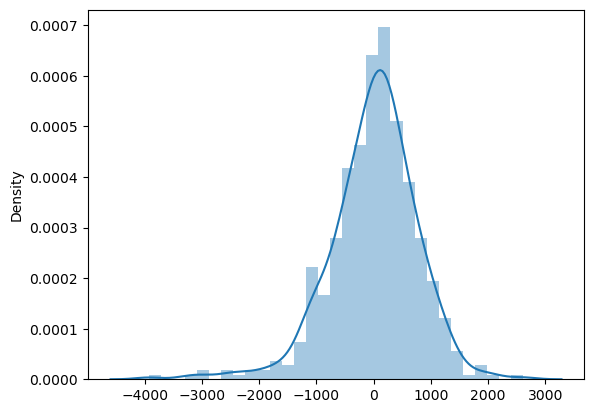

In [863]:
res = y_train - y_train_pred

sns.distplot(res)

We see that the error terms are normally distribution with mean as 0. This is allinged with the assumptions made for Linear Regression.

#### Step 5 - Predictions and Evaluation

Since we have finalised with the model and verified the error terms are normally distributed, we now proceed with the Predictions using the final model.
We will use the test dataset to predict the target variable cnt. 

In [864]:
# Apply the scaling on the test dataset

num_varlist

['temp', 'atemp', 'hum', 'windspeed']

In [865]:
bike_test[num_varlist] = scaler.transform(bike_test[num_varlist])

In [866]:
bike_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thrusday,weekday_Tuesday,weekday_Wednesday,weathersit_LightSnow+Rain,weathersit_Mist+Cloudy
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.0,220.0,...,220.0,220.0,220.0,220.0,220.0,220.0,220.0,220.0,220.0,220.0
mean,0.481818,0.036364,0.700000,0.558718,0.532847,0.638221,0.313293,4560.559091,0.254545,0.263636,...,0.086364,0.086364,0.127273,0.118182,0.145455,0.163636,0.168182,0.1,0.027273,0.318182
std,0.500809,0.187620,0.459303,0.233187,0.217401,0.148694,0.159584,1904.968544,0.436599,0.441609,...,0.281541,0.281541,0.334038,0.323559,0.353363,0.370789,0.374881,0.300684,0.163248,0.466833
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,441.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,3312.750000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,4582.500000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.000000,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,5913.000000,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,8395.000000,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [867]:
# Separate target variable cnt
y_test = bike_test.pop('cnt')
x_test = bike_test

In [868]:
x_test_sm = sm.add_constant(x_test)
x_test_sm.head()

,const,yr,holiday,workingday,temp,atemp,hum,windspeed,season_Spring,season_Summer,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thrusday,weekday_Tuesday,weekday_Wednesday,weathersit_LightSnow+Rain,weathersit_Mist+Cloudy
184,1.0,0,1,0,0.831783,0.769660,0.657364,0.084219,0,0,...,0,0,1,0,0,0,0,0,0,1
535,1.0,1,0,1,0.901354,0.842587,0.610133,0.153728,0,1,...,0,0,0,0,0,0,0,1,0,0
299,1.0,0,0,1,0.511964,0.496145,0.837699,0.334206,0,0,...,1,0,0,0,0,1,0,0,0,1
221,1.0,0,0,1,0.881625,0.795343,0.437098,0.339570,0,0,...,0,0,0,0,0,0,0,1,0,0
152,1.0,0,0,1,0.817246,0.741471,0.314298,0.537414,0,1,...,0,0,0,0,0,1,0,0,0,0


In [869]:
model_col_list = x_train_lm.columns

In [870]:
x_test_sm = x_test_sm[model_col_list]
x_test_sm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220 entries, 184 to 653
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   const                      220 non-null    float64
 1   yr                         220 non-null    int64  
 2   workingday                 220 non-null    int64  
 3   temp                       220 non-null    float64
 4   windspeed                  220 non-null    float64
 5   season_Summer              220 non-null    Int64  
 6   season_Winter              220 non-null    Int64  
 7   mnth_August                220 non-null    Int64  
 8   mnth_December              220 non-null    Int64  
 9   mnth_February              220 non-null    Int64  
 10  mnth_January               220 non-null    Int64  
 11  mnth_November              220 non-null    Int64  
 12  mnth_September             220 non-null    Int64  
 13  weekday_Saturday           220 non-null    Int64  
 1

In [871]:
x_test_sm.head()

,const,yr,workingday,temp,windspeed,season_Summer,season_Winter,mnth_August,mnth_December,mnth_February,mnth_January,mnth_November,mnth_September,weekday_Saturday,weathersit_LightSnow+Rain,weathersit_Mist+Cloudy
184,1.0,0,0,0.831783,0.084219,0,0,0,0,0,0,0,0,0,0,1
535,1.0,1,1,0.901354,0.153728,1,0,0,0,0,0,0,0,0,0,0
299,1.0,0,1,0.511964,0.334206,0,1,0,0,0,0,0,0,0,0,1
221,1.0,0,1,0.881625,0.339570,0,0,1,0,0,0,0,0,0,0,0
152,1.0,0,1,0.817246,0.537414,1,0,0,0,0,0,0,0,0,0,0


In [872]:
y_test_pred = lr_model.predict(x_test_sm)

#### R-Squared Value
The R-squared value provides the goodness of the fit for the model. The scale of R^2 is between 0-100%. It explains the variance of dependent variable which independent variables will be able to explain.

In [873]:
# R^2 value for Test and Predicted values.
r2_score(y_true=y_test, y_pred=y_test_pred)

0.8095370585769065

#### Conclusion 
The regression model when applied on the test dataset gives R-quared value of 80.95%. The R-sqaured value on training dataset is 84.4%. These values are quite reasonable and indicates that the model which is based on the training data can be safely applied on the test dataset.

In [874]:
# the following are the coefficents and their corresponding parameters
lr_model.params

const                        1376.136292
yr                           2037.564196
workingday                    470.927329
temp                         3821.320784
windspeed                   -1432.570018
season_Summer                 678.553220
season_Winter                1148.661579
mnth_August                   387.412891
mnth_December                -469.014797
mnth_February                -402.523421
mnth_January                 -692.510757
mnth_November                -377.013691
mnth_September                850.176660
weekday_Saturday              561.274795
weathersit_LightSnow+Rain   -2566.731016
weathersit_Mist+Cloudy       -714.612723
dtype: float64

In [875]:
# Regression line is represented by following equation
n=0
equation = ''
for i in lr_model.params:
    #print(equation)
    if lr_model.params.index[n] == 'const':
        equation = str(round(lr_model.params.values[n], 3))
    else:
        equation= equation + " + " + str(round(lr_model.params.values[n], 3)) + ' * ' + lr_model.params.index[n]
    n+=1

In [876]:
equation

'1376.136 + 2037.564 * yr + 470.927 * workingday + 3821.321 * temp + -1432.57 * windspeed + 678.553 * season_Summer + 1148.662 * season_Winter + 387.413 * mnth_August + -469.015 * mnth_December + -402.523 * mnth_February + -692.511 * mnth_January + -377.014 * mnth_November + 850.177 * mnth_September + 561.275 * weekday_Saturday + -2566.731 * weathersit_LightSnow+Rain + -714.613 * weathersit_Mist+Cloudy'

Reqression Line represented by the by the following equation is the best fitted line from the above analysis.

cnt = 1376.136 + 2037.564 * yr + 470.927 * workingday + 3821.321 * temp + -1432.57 * windspeed + 678.553 * season_Summer + 1148.662 * season_Winter + 387.413 * mnth_August + -469.015 * mnth_December + -402.523 * mnth_February + -692.511 * mnth_January + -377.014 * mnth_November + 850.177 * mnth_September + 561.275 * weekday_Saturday + -2566.731 * weathersit_LightSnow+Rain + -714.613 * weathersit_Mist+Cloudy

The coefficients indicate
1. Positive coefficents indicate that the increase in variables will increase in value of the target variable.
2. Negative coefficents indicate that the increase in variables will decrease in value of the target variable.

From the above equation we conclude
1. From the R-squared value of training and test dataset we conclude that the variables can explain the about 81% of the demand in bike sharing.
2. Coefficents of the variables helps in understanding the magnitude of their impact on bike sharing.
3. We see that top three variables which positively impact are temp, yr and season_winter.
4. We see that top three variables which negatively impact are windspeed, weathersit_LightSnow+Rain and weathersit_Mist+Cloudy.
5. So from original dataset we see that major factors will be temp, season, weathersit and mnth.

#### Recommendations by Regression model
1. Increase in temp will drive higher demand for bike sharing.
2. During Winter season there is expected increase in numbers for bike sharing.
3. Demand is high during working day and saturdays.
4. Demand will be less on days with high wind speed.